In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-3febf6aafd08>:76: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i / len(labels)), label=label, edgecolor='k', s=50)


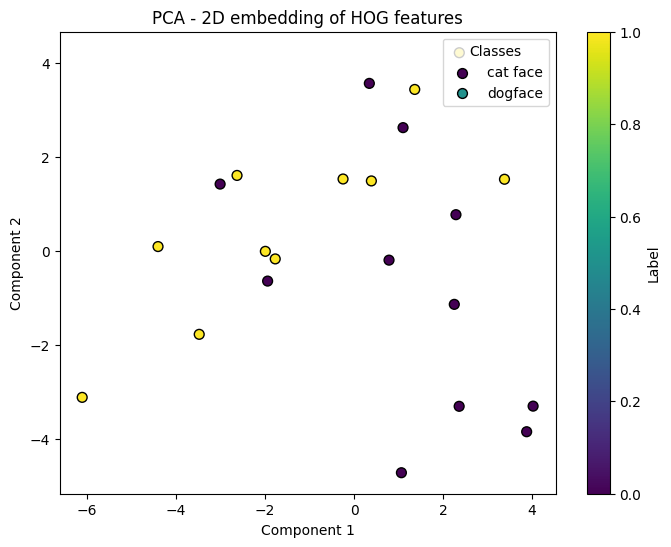

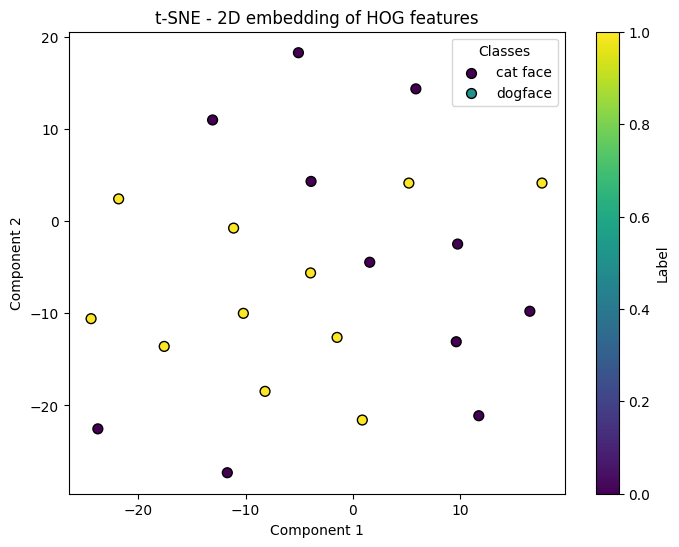

In [1]:
import cv2
import numpy as np
from skimage.feature import hog
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 이미지 크기 설정
image_size = (128, 128)

# HOG 특징 추출 함수
def extract_hog_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"이미지 로드 실패: {image_path}")
        return None  # 이미지가 로드되지 않으면 None을 반환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, image_size)
    features, hog_image = hog(resized_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# 훈련 데이터 로드 및 벡터화
def load_training_data(data_dir):
    features = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                file_path = os.path.join(label_dir, filename)
                if file_path.endswith('.jpg') or file_path.endswith('.png'):
                    feature = extract_hog_features(file_path)
                    if feature is not None:
                        features.append(feature)
                        labels.append(label)
    return np.array(features), np.array(labels)
# 로드할 때부터 그레이로 불러오가 수정
# 훈련 데이터 경로
train_dir = '/content/drive/MyDrive/ColabNotebooks/faceimage'

# 훈련 데이터 준비
X_train, y_train = load_training_data(train_dir)

# 레이블을 숫자로 변환
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# PCA로 차원 축소
pca = PCA(n_components=2)  # 2D로 축소
X_train_pca = pca.fit_transform(X_train)

# t-SNE로 차원 축소
tsne = TSNE(n_components=2, perplexity=10, random_state=42)  # perplexity 값 조정
X_train_tsne = tsne.fit_transform(X_train)

# 시각화 함수 (PCA 또는 t-SNE 결과를 플로팅)
def plot_embedding(X, y, title="Dog or Cat"):
    plt.figure(figsize=(8, 6))

    # 색상 맵을 사용해 레이블에 맞는 색을 설정
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

    # 제목 설정
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # 범례 (레이블을 텍스트로 표시)
    plt.colorbar(scatter, label='Label')

    # 범례로 `cat`과 `dog`의 레이블과 색을 표시
    labels = le.classes_  # 레이블 목록 (예: ['cat', 'dog'])
    for i, label in enumerate(labels):
        plt.scatter([], [], c=plt.cm.viridis(i / len(labels)), label=label, edgecolor='k', s=50)

    plt.legend(title="Classes", loc="upper right")
    plt.show()

# PCA 결과 시각화
plot_embedding(X_train_pca, y_train_encoded, title="PCA - 2D embedding of HOG features")

# t-SNE 결과 시각화
plot_embedding(X_train_tsne, y_train_encoded, title="t-SNE - 2D embedding of HOG features")


In [4]:
def predict_new_image(image_path, model, pca, label_encoder):
    # HOG 특징 추출
    feature = extract_hog_features(image_path)
    if feature is None:
        return "이미지 로드 실패"
    # PCA 변환
    feature_pca = pca.transform([feature])
    # SVM 예측
    prediction = model.predict(feature_pca)
    # 예측된 레이블 반환
    return label_encoder.inverse_transform(prediction)[0]


In [5]:
def plot_svm_decision_boundary(X, y, model, pca, label_encoder, new_images=None, new_image_preds=None):
    plt.figure(figsize=(10, 8))

    # 결정 경계 그리기
    h = 0.02  # 격자 간격
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

    # 기존 데이터 산점도
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

    # 새로운 이미지 시각화
    if new_images and new_image_preds:
        for i, (image_path, pred) in enumerate(zip(new_images, new_image_preds)):
            # 새 이미지를 PCA로 변환
            feature = extract_hog_features(image_path)
            if feature is not None:
                feature_pca = pca.transform([feature])
                plt.scatter(feature_pca[0, 0], feature_pca[0, 1], c='red', marker='x', s=100, label=f"New {i+1}: {pred}")

    # 범례 및 설정
    plt.legend()
    plt.title("SVM Decision Boundary with New Images")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Classes")
    plt.show()


새로운 이미지 1의 예측된 레이블: cat face
새로운 이미지 2의 예측된 레이블: dogface


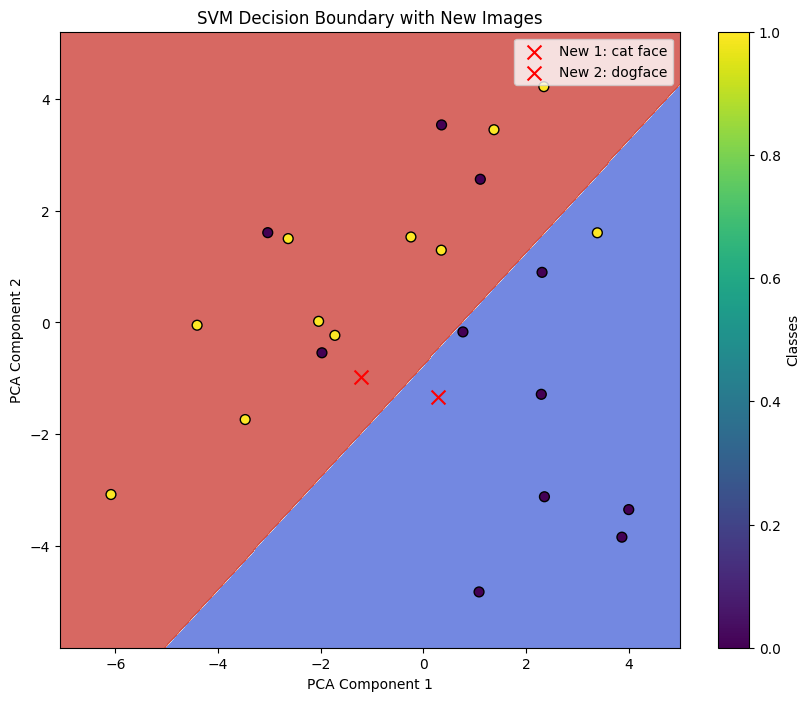

이 이미지는 강아지상입니다!
이 이미지는 강아지상입니다!


In [8]:

new_images = [
    '/content/drive/MyDrive/ColabNotebooks/test_image/test1.jpeg',
    '/content/drive/MyDrive/ColabNotebooks/test_image/test2.jpeg'
]

# 여러 이미지에 대해 예측
new_image_preds = [predict_new_image(image_path, svm_classifier, pca, le) for image_path in new_images]

# 새로운 이미지 예측 결과 출력
for i, pred in enumerate(new_image_preds):
    print(f"새로운 이미지 {i+1}의 예측된 레이블: {pred}")

# SVM 결정 경계 시각화 (누적된 새 이미지들 포함)
plot_svm_decision_boundary(X_train_pca, y_train_encoded, svm_classifier, pca, le, new_images=new_images, new_image_preds=new_image_preds)

# 예측된 클래스 텍스트 출력
for pred in new_image_preds:
    if pred == 'catface':
        print("이 이미지는 고양이상입니다!")
    else:
        print("이 이미지는 강아지상입니다!")
